Treinando uma rede neural
=========================



## Introdução



Depois de uma longa jornada, finalmente chegamos ao *season finale* da nossa saga para construir uma rede neural artificial em Python puro. Agora que já conseguimos criar uma rede neural, o próximo passo é treinar essa rede.



## Objetivo



Treinar uma rede neural artificial tipo Multilayer Perceptron usando Python.



## Importações



In [1]:
import random
from classes import Valor
from funcoes import plota_grafo

## Código e discussão



### Classes



Abaixo estão as classes que criamos no notebook anterior. Elas são as classes de base para criarmos nossa rede neural MLP. Ao longo deste notebook vamos fazer as últimas modificações nelas.



In [2]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        pesos = []

        for _ in range(num_dados_entrada):
            peso = Valor(random.uniform(-1, 1))
            pesos.append(peso)

        self.pesos = pesos
        self.vies = Valor(random.uniform(-1, 1))

    def __call__(self, x):
        """Executa a computação interna do neurônio.

        Args:
          x: lista de valores de entrada (informação que chega ao neurônio).

        Returns:
          Informação que o neurônio propaga adiante. Trata-se da
          aplicação da função de ativação à soma de `x` vezes os pesos do
          neurônio adicionado ao viés.
        """
        assert len(x) == len(self.pesos), "Seu x tem tamanho errado."

        soma = 0
        for x_, p in zip(x, self.pesos):
            soma = soma + x_ * p

        soma = soma + self.vies
        dado_de_saida = soma.sig()
        return dado_de_saida
    
    def parametros(self):
        return self.pesos + [self.vies] #retorna os parâmetros


class Camada:
    def __init__(self, num_dados_entrada, num_neuronios):
        neuronios = []

        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)

        self.neuronios = neuronios

    def __call__(self, x):
        """Executa a computação de cada neurônio da camada.

        Args:
          x: lista de valores de entrada (informação que chega aos neurônios).

        Returns:
          Informação que os neurônios da camada propagam adiante.
        """
        saidas = []

        for neuronio in self.neuronios:
            informacao = neuronio(x)
            saidas.append(informacao)

        if len(saidas) == 1:
            return saidas[0]
        else:
            return saidas
        
    def parametros(self):
        params = []
        for neuronios in self.neuronios:
            params.extend(neuronios.parametros()) #pega os parametros de cada neuroio. extend ao invés de append, quer-se apenas uma lista, não uma lista de valores com uma lista
        return params


class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):

        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []

        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(percurso[i], percurso[i+1])
            camadas.append(camada)

        self.camadas = camadas

    def __call__(self, x):
        """Executa a computação de cada camada.

        Como a rede MLP é uma rede feedforward, a informação que uma camada
        recebe é a informação de saída da camada anterior. A única exceção é a
        camada de entrada, onde a informação é fornecida pelo usuário

        Args:
          x: informação fornecida na camada de entrada.

        Returns:
          Informação recuperada na camada de saída.
        """
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camadas in self.camadas:
            params.extend(camadas.parametros())
        return params

### A função de perda (*loss function*)



Fomos ao laboratório e sintetizamos 4 amostras de [complete com o que quiser]. Cada uma dessas amostras foi feita variando 3 parâmetros de processamento diferentes. Estas amostras e seus parâmetros de processamento estão representados na variável `x` abaixo.

Levamos essas 4 amostras no equipamento [complete com o que quiser] e obtivemos uma resposta que está representada na variável `y_true` abaixo.



In [3]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

Queremos treinar uma MLP que seja capaz de modelar o comportamento que observamos. Isto é, queremos uma rede neural que receba informação sobre os 3 parâmetros de processamento e que com isso seja capaz de prever qual o resultado que teríamos no equipamento que mencionamos no parágrafo anterior.

Vamos, primeiramente, criar uma rede neural simples do tipo MLP.



In [4]:
NUM_DADOS_DE_ENTRADA = 3  # são 3 parâmetros que descrevem cada amostra
NUM_DADOS_DE_SAIDA = 1    # queremos apenas um valor de saída por amostra
CAMADAS_OCULTAS = [3, 2]  # fique à vontade para alterar aqui

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

Com nossa rede criada, podemos realizar uma previsão! Mas muito provavelmente esta previsão será bastante subótima.



In [5]:
y_pred = []

for x_ in x:
    valor_previsto = minha_mlp(x_)
    y_pred.append(valor_previsto)

print(y_true)
print(y_pred) #dados, porém sem treinamento. Treinamento: diminuir os parâmetros da rede.
#Função de perda: quantificar a previsão, o quão bom foi a previsão.
#Regressão: os números mais próximo possível. Quadrados mínimos é a função de perda.
#Nota: quadrados mínimos é pegar a diferença das distâncias do previsto e real, ao quadrado e somar. diminuir esse valor

[1, 0, 0.2, 0.5]
[Valor(data=0.5713512589430243), Valor(data=0.5655266153792297), Valor(data=0.5692186627360863), Valor(data=0.5686922883089552)]


Nosso resultado, assim como esperado, é bastante subótimo. Mas como quantificar isso? Seria bom se existisse uma forma de quantificar em um único número o quão boa está a previsão da minha rede.

Uma forma de quantificar a qualidade da previsão é usando uma `função de perda`, mais conhecida como `loss function`. Aqui podemos, por exemplo, computar a soma dos erros quadráticos. Esta é uma função de perda muito usada em problemas de regressão.



In [6]:
erros_quadrados = []

for yt, yp in zip(y_true, y_pred):
    erro_quadratico = (yp - yt) ** 2
    erros_quadrados.append(erro_quadratico)

loss = sum(erros_quadrados) #sempre se quer minimizar a perda
print(loss) #perda da rede neural NÃO treinada. o não treinamento faz com que se role dados todas as vezes

Valor(data=0.6446011472977617)


A variável `loss` é uma medida da performance da rede neural que criamos. Essa variável é uma instância de `Valor`, logo podemos facilmente observar o grafo computacional desta métrica.



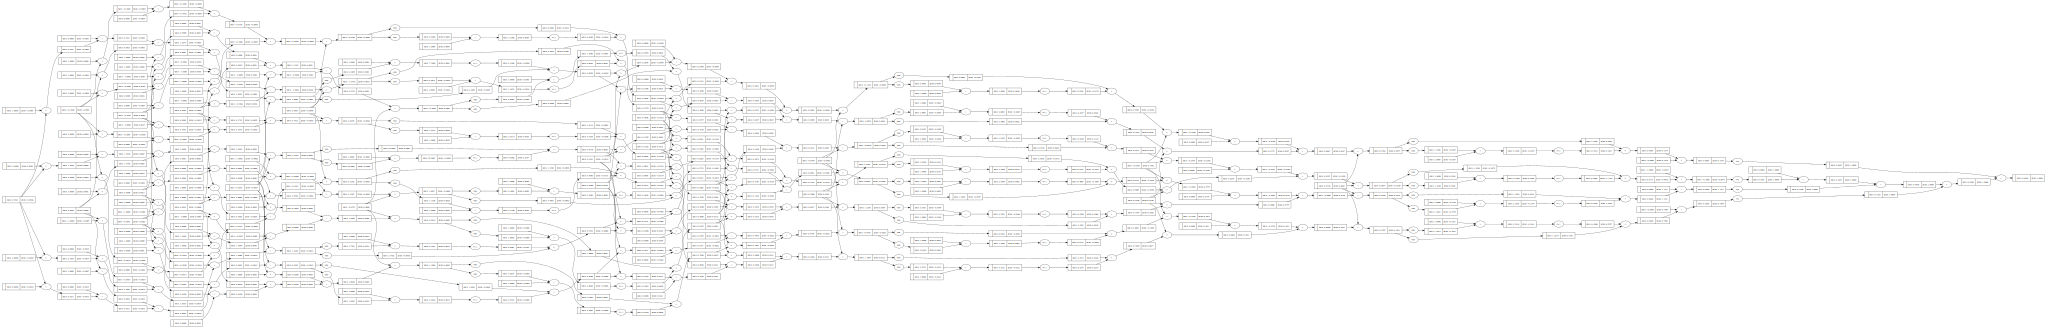

In [7]:
loss.propagar_tudo()
grafo = plota_grafo(loss)
grafo.render("rede_neural", format="png")
grafo

### Treinando a rede através da atualização dos parâmetros



Como vimos acima, o grafo computacional da nossa rede neural é bastante complexo! Cheio de vértices!

Nosso objetivo é treinar a rede neural que criamos, sendo que para isso precisamos alterar os parâmetros internos da rede. O primeiro passo para fazer isso é alterar as nossas classes de forma que o código abaixo funcione.



In [8]:
parametros = minha_mlp.parametros()
#parâmetros são os valores da RN que se pode mudar.. vértices e dados não mudam. parâmetros: pesos e bias dos neurônios
print(len(parametros))
print()
parametros

23



[Valor(data=0.7221232699251603),
 Valor(data=0.5053257724222002),
 Valor(data=-0.6060681902142724),
 Valor(data=-0.02508019135218853),
 Valor(data=-0.10279493515255611),
 Valor(data=-0.47626825222683933),
 Valor(data=0.3465653089649652),
 Valor(data=0.30667440004266),
 Valor(data=0.4997902732337349),
 Valor(data=0.6933270828552953),
 Valor(data=0.9208208451153443),
 Valor(data=-0.6750635166820287),
 Valor(data=0.34313488181921636),
 Valor(data=0.46082091351258425),
 Valor(data=0.18018786691793554),
 Valor(data=-0.6447109492235708),
 Valor(data=0.29046045330805526),
 Valor(data=0.15915840697409367),
 Valor(data=0.5085503622969398),
 Valor(data=0.548794269690897),
 Valor(data=-0.5792635009987759),
 Valor(data=0.373837927896137),
 Valor(data=0.2718211417898735)]

Agora que conseguimos &ldquo;extrair&rdquo; os parâmetros da nossa MLP, podemos fazer o treino deles! Temos que pensar bem como alterar os parâmetros da maneira correta. Lembre-se que nosso desejo é reduzir a métrica computada pela função de perda.



In [9]:
TAXA_DE_APRENDIZADO = 0.01
for p in minha_mlp.parametros():
# gradiente é a aproximação linear local para uma superfície de n dimensões, pode-se aumentar a perda
#o gradiente indica  a tendência para aumentar a perda, sempre pegar o INVERSO
#o gradiente é usado para diminuir a perda. isso se dá pela interpretação do gradiennte, assim, vá contra o gradiente.
    p.data = p.data - p.grad * TAXA_DE_APRENDIZADO #a taxa de aprendizado serve para dar um "pequeno passo" em direção oa inverso do gradiente, não se quer pular um mínimo na hipersuperfície de n dimensões (n é o número de dimensões)
#quando atualizado o p.data, deve-se calcular o "ZERO_GRAD". deve-se recalcular o gradiente toda vez que aplicado a taxa de aprendizado. Acumula o gradiente

Lembre_se re recualcular o gradiente antes de fazer a previsão

Agora que executamos um &ldquo;ciclo&rdquo; de treino, podemos observar o impacto disso!



In [10]:
y_pred = []
for x_ in x:
    valor_previsto = minha_mlp(x_)
    y_pred.append(valor_previsto)

erros_quadrados = []
for yt, yp in zip(y_true, y_pred):
    erro_quadratico = (yp - yt) ** 2
    erros_quadrados.append(erro_quadratico)

loss = sum(erros_quadrados)
loss.propagar_tudo()
print(loss)

Valor(data=0.6430885424611195)


#### Definição de época: toda vez que a rede neural passa os dados pela rede, computa a perda e passa o gradiente, chama-se isso de uma época

### A descida do gradiente



#### Descida do gradiente: recálculo do gradiente depois de atualizar o p.data
#### Passou todos os dados pela rede: época

Apenas um &ldquo;ciclo&rdquo; de treino costuma não ser suficiente para treinarmos uma rede neural, precisamos de mais! Antes de seguir em frente, vamos definir um termo: chamamos de `época` toda vez que nossa rede neural propaga *todo* nosso dataset. É comum treinarmos redes neurais por dezenas, centenas e até milhares de épocas!

Vamos programar um treino completo da rede neural!

Um detalhe: sempre temos que zerar os gradientes antes de fazer o backpropagation. Isso é necessário pois cada vez que alteramos os parâmetros estaremos em outra posição da curva de perda e os gradientes antigos já não são mais válidos.



In [11]:
NUM_DADOS_DE_ENTRADA = 3  # são 3 parâmetros que descrevem cada amostra
NUM_DADOS_DE_SAIDA = 1    # queremos apenas um valor de saída por amostra
CAMADAS_OCULTAS = [3, 2]  # fique à vontade para alterar aqui

x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]
minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [12]:
NUM_EPOCAS = 10
TAXA_DE_APRENDIZADO = 0.1 #empírico, caso for muito grande, o erro pode aumentar 

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for x_ in x:
        previsao = minha_mlp(x_)
        y_pred.append(previsao)

    # zero grad #cada atualização de p.data, tem-se novos valores com novos gradientes.
    for p in minha_mlp.parametros():
        p.grad = 0 #mudança de propriedade da mão
    
    # loss
    loss = []
    for yp,yt in zip(y_pred,y_true):
        loss.append((yp-yt)**2)
    loss = sum(loss)

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado #opcional
    print(epoca, loss.data) #a perda é o termômetro de o quão bom ou ruim foi o treino

0 0.7077366981987124
1 0.690926235412614
2 0.6749538962469877
3 0.6599338656678312
4 0.6459532760264467
5 0.6330696274175223
6 0.6213103145329056
7 0.6106741452669604
8 0.6011345032021822
9 0.5926436560185704


Após o treino, podemos checar se nossa rede é capaz de prever os dados que coletamos com boa performance.



In [13]:
print(y_true)
print(y_pred)

[1, 0, 0.2, 0.5]
[Valor(data=0.3301500733636447), Valor(data=0.31415695496787777), Valor(data=0.32956758179963513), Valor(data=0.3312920239118926)]


Esse processo de atualizar os parâmetros da rede neural observando os gradientes locais é chamado de `descida do gradiente` (ou apenas `método do gradiente`).



## Conclusão



Este notebook tem o objetivo de, finalmente, treinar uma rede neural (por meio de python puro). Sendo assim, foi-se importado a Classe Valor (que possui operações matemáticas necessárias para os cálculos da rede neural) e copiado no notebook anterior as classes Neuronio, Camada e MLP, que computam a rede neural. Para treinar a rede neural, foi-se utilizado a descida do gradiente com o fim de otimizar os parâmetros (viés/bias e weights/pesos), em várias épocas, com o fim de minimizar a função de perda. Nota-se que a função de perda foi realizada a partir de quadrados mínimos. Assim, por meio da alteração dos parâmteros com base na taxa de aprendizado utilizada por meio do gradiente, tem-se o o objetivo de minimizar a função de perda e, consequentemente, aumentar a precisão de dado modelo. Nota-se que como o código é algo mais próximo do python puro, este é, naturalmente, menos eficiente do que bibliotecas como _tensorflow_ ou _pytorch_. Mesmo assim, é interessante como um modelo didático, com o fim de explicitar conceitos e esclarecer ideias.

## Playground

